In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(cowplot)
library(digest)
library(repr)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

## Outline

1. read data, select "Post Hour" and "Likes", "Comments", "Shares"
2. split data
3. create knn regression model
        - find best k in workflow using training data
        - refit the model with test data
4. create simple linear regression model
5. create new tibble with every hour
6. find "Likes", "Comments", "Shares" for each hour using knn regression and linear regression models
7. find hour with highest "Likes", "Comments", "Shares"

When is the best month, weekday, and hour to post for the highest engagement in comments, likes, and shares?

In [2]:
#reading the data
temp <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00368/Facebook_metrics.zip",temp)

#Reading the data in R
facebook <- read_csv2(unz(temp, "dataset_Facebook.csv"))
head(facebook)
unlink(temp)
facebook

#fill in blank values with 0
facebook[is.na(facebook)] <- 0

Using ',' as decimal and '.' as grouping mark. Use read_delim() for more control.

Parsed with column specification:
cols(
  `Page total likes` = col_double(),
  Type = col_character(),
  Category = col_double(),
  `Post Month` = col_double(),
  `Post Weekday` = col_double(),
  `Post Hour` = col_double(),
  Paid = col_double(),
  `Lifetime Post Total Reach` = col_double(),
  `Lifetime Post Total Impressions` = col_double(),
  `Lifetime Engaged Users` = col_double(),
  `Lifetime Post Consumers` = col_double(),
  `Lifetime Post Consumptions` = col_double(),
  `Lifetime Post Impressions by people who have liked your Page` = col_double(),
  `Lifetime Post reach by people who like your Page` = col_double(),
  `Lifetime People who have liked your Page and engaged with your post` = col_double(),
  comment = col_double(),
  like = col_double(),
  share = col_double(),
  `Total Interactions` = col_double()
)



Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
139441,Photo,2,12,2,3,0,7244,13594,671,410,580,6228,3200,396,19,325,49,393
139441,Status,2,12,1,9,0,10472,20849,1191,1073,1389,16034,7852,1016,1,152,33,186


Page total likes,Type,Category,Post Month,Post Weekday,Post Hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,Total Interactions
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
139441,Photo,2,12,4,3,0,2752,5091,178,109,159,3078,1640,119,4,79,17,100
139441,Status,2,12,3,10,0,10460,19057,1457,1361,1674,11710,6112,1108,5,130,29,164
139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
81370,Photo,1,1,5,2,0,3778,7216,625,572,795,4742,2388,363,4,93,18,115
81370,Photo,3,1,4,11,0,4156,7564,626,574,832,4534,2452,370,7,91,38,136
81370,Photo,2,1,4,4,NA,4188,7292,564,524,743,3861,2200,316,0,91,28,119


Looking at our dataset, it passes the test for tidy data (each row is a single observation, each column is a single variable, each value is a single cell), so no further cleaning data tools are required. However, the column names are separated by white spaces instead of underscores (_). We will deal with this issue first and rename our predictor columns to additional headaches along the way. 

Before we'll get ahead with our exploratory data analysis, we'll split the data into training and testing data to perform a quick summary of the training dataset, including the number of rows, the number of columns, the number of rows with missing data values, and the mean of our predictor variables.

In [10]:
#Renaming "Post Hour"
facebook_1 <- facebook %>% rename(post_hour = `Post Hour`) 
facebook_1 <- facebook_1 %>% rename(total_interactions = `Total Interactions`) 
facebook_filtered <- facebook_1 %>% filter(total_interactions < 5000) 

#Split into training (75 percent of data set) and test data
set.seed(2021)
facebook_split <- initial_split(facebook_filtered, prop = 0.75, strata = total_interactions)
facebook_train <- training(facebook_split)
facebook_test <- testing(facebook_split)


#Missing Rows of Data
missing_rows <- sum(colSums(is.na(facebook_train)))

#Average of Each Predictor Variable
average_likes <- mean(facebook_train[["like"]])
average_comments <- mean(facebook_train[["comment"]])
average_shares <- mean(facebook_train[["share"]])
average_total_interactions <- mean(facebook_train[["total_interactions"]])

#Total Number of Observations
observation_total <- nrow(facebook_train)

#Total Number of Variables
variable_total <- ncol(facebook_train)

#Exploratory Data Analysis Table
exploratory_table <- facebook_train %>%
                     mutate(facebook_train, observation_total = observation_total) %>%
                     mutate(facebook_train, variable_total = variable_total) %>%
                     mutate(facebook_train, average_likes = average_likes) %>%
                     mutate(facebook_train, average_comments = average_comments) %>%
                     mutate(facebook_train, average_shares = average_shares) %>%
                     mutate(facebook_train, average_total_interactions = average_total_interactions) %>%
                     mutate(facebook_train, missing_rows = missing_rows) %>%
                     select(observation_total, variable_total, average_likes, average_comments, average_shares, average_total_interactions,
                            missing_rows) %>%
                     slice(1)
exploratory_table
#facebook <- facebook %>% 
  #  select("Post Hour", "like", "comment", "share") %>% 
   # rename(post_hour = "Post Hour")
#facebook

observation_total,variable_total,average_likes,average_comments,average_shares,average_total_interactions,missing_rows
<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
376,19,160.4761,6.305851,24.56915,191.3511,0


Decription of us using highest engagment from this point forward.

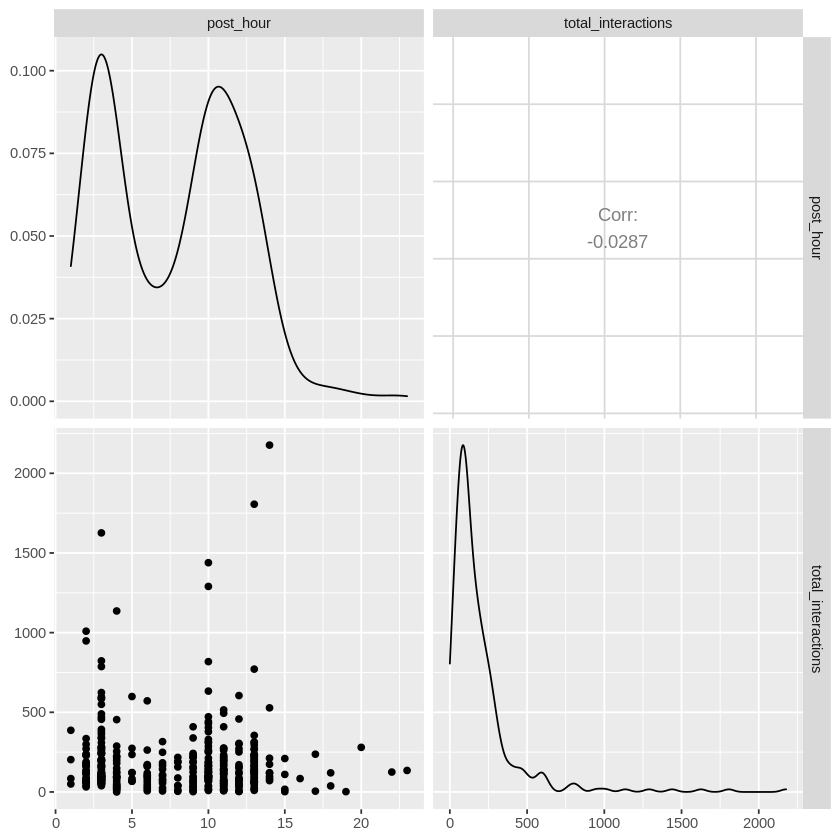

In [11]:
#Ggpairs
facebook_ggpairs <- facebook_train %>%                 
                    select(post_hour, total_interactions) %>%
                    ggpairs()
facebook_ggpairs

This makes sense to have no correlation considering there shouldn't be a relationship between post_hour and total_interactions

## Predicting Best Post Hour

In [12]:
set.seed(2021)
#Recipe for Post Hour
facebook_recipe <- recipe(total_interactions ~ post_hour, data = facebook_train) %>%
                   step_scale(all_predictors()) %>%
                   step_center(all_predictors())
#Model
facebook_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                 set_engine("kknn") %>%
                 set_mode("regression")

#5 fold cross validation
facebook_vfold <- vfold_cv(facebook_train, v = 5, strata = total_interactions)

#workflow
facebook_workflow <- workflow() %>%
                     add_recipe(facebook_recipe) %>%
                     add_model(facebook_spec)

#testing 200 values to find the best value for K
gridvals <- tibble(neighbors = seq(1, 200))

#Tuning workflow to test the values of K
facebook_results <- facebook_workflow %>%
                        tune_grid(resamples = facebook_vfold, grid = gridvals) %>%
                        collect_metrics()
#Min amount of RMSPE along with mean and standard error to find the best K value to use
facebook_min <- facebook_results %>%
    filter(.metric == "rmse") %>%
    arrange(mean)  %>% 
    slice(1)

facebook_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
126,rmse,standard,226.7611,5,38.79135,Model126


narration

In [13]:
#Min RMSPE
set.seed(2021)
k_min <- facebook_min %>%
            pull(neighbors)

#Using the best K in our model
facebook_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                            set_engine("kknn") %>%
                            set_mode("regression")

#Reworking the workflow to incorporate our chosen K
facebook_best_fit <- workflow() %>%
                        add_recipe(facebook_recipe) %>%
                        add_model(facebook_best_spec) %>%
                        fit(data = facebook_train)

#Summary of the training vs testing data
facebook_summary <- facebook_best_fit %>% 
                       predict(facebook_test) %>%
                       bind_cols(facebook_test) %>%
                       metrics(truth = total_interactions, estimate = .pred)  
facebook_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.296946e+02
rsq,standard,7.137349e-04
mae,standard,1.755847e+02


Narration

.pred,Page total likes,Type,Category,Post Month,Post Weekday,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
215.2381,139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
175.4524,139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
175.4524,138414,Status,2,12,3,10,0,10060,19680,1264,1209,1425,17272,8548,1162,4,86,18,108
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
205.5317,85093,Photo,3,1,1,2,0,8412,13960,1179,1111,1632,8632,5348,699,17,185,55,257
178.6587,81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
203.0635,81370,Photo,2,1,4,4,0,4188,7292,564,524,743,3861,2200,316,0,91,28,119


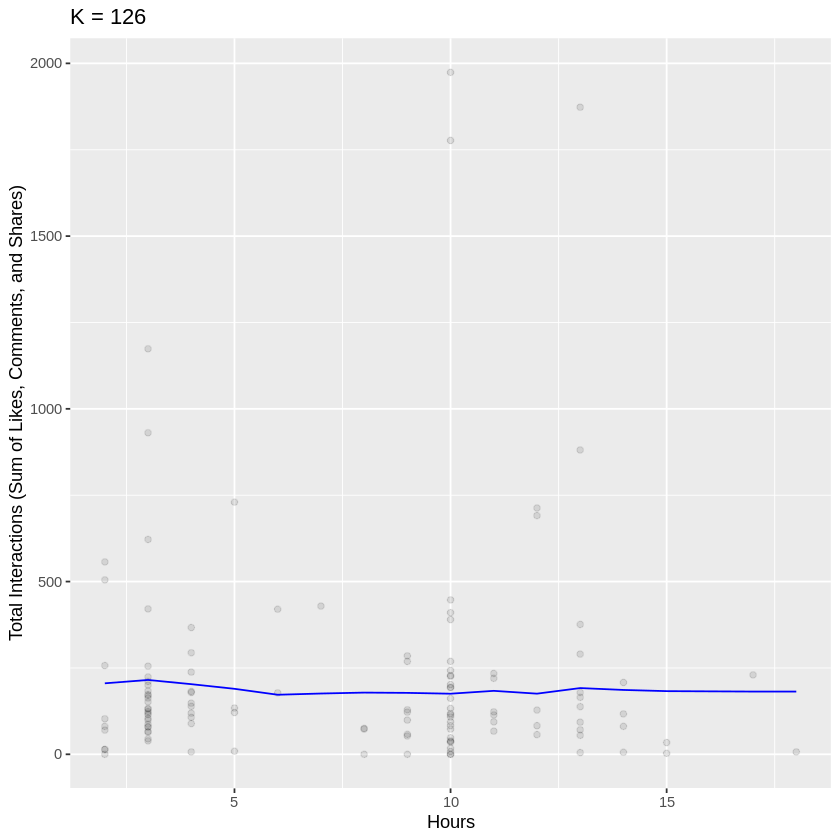

In [14]:
set.seed(2021)
facebook_preds <- facebook_best_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_preds
facebook_plot_final <- ggplot(facebook_preds, aes(x = post_hour, y = total_interactions)) +
                       geom_point(alpha = 0.1) +
                       xlab("Hours") +
                      ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                      geom_line(data = facebook_preds, aes(x = post_hour, y = .pred), color = "blue") +
                      ggtitle(paste0("K = ", k_min))
facebook_plot_final

In [15]:
summary(facebook_preds)

     .pred       Page total likes     Type              Category    
 Min.   :172.4   Min.   : 81370   Length:123         Min.   :1.000  
 1st Qu.:175.6   1st Qu.:106928   Class :character   1st Qu.:1.000  
 Median :189.6   Median :128032   Mode  :character   Median :2.000  
 Mean   :192.0   Mean   :120758                      Mean   :1.813  
 3rd Qu.:205.5   3rd Qu.:136393                      3rd Qu.:3.000  
 Max.   :215.2   Max.   :139441                      Max.   :3.000  
   Post Month      Post Weekday     post_hour           Paid       
 Min.   : 1.000   Min.   :1.000   Min.   : 2.000   Min.   :0.0000  
 1st Qu.: 4.000   1st Qu.:3.000   1st Qu.: 3.000   1st Qu.:0.0000  
 Median : 7.000   Median :4.000   Median : 9.000   Median :0.0000  
 Mean   : 6.724   Mean   :4.276   Mean   : 7.707   Mean   :0.2846  
 3rd Qu.:10.000   3rd Qu.:6.000   3rd Qu.:10.000   3rd Qu.:1.0000  
 Max.   :12.000   Max.   :7.000   Max.   :18.000   Max.   :1.0000  
 Lifetime Post Total Reach Lifetime Post 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,3.292454e+02
rsq,standard,1.541205e-03
mae,standard,1.742192e+02


.pred,Page total likes,Type,Category,Post Month,Post Weekday,post_hour,Paid,Lifetime Post Total Reach,Lifetime Post Total Impressions,Lifetime Engaged Users,Lifetime Post Consumers,Lifetime Post Consumptions,Lifetime Post Impressions by people who have liked your Page,Lifetime Post reach by people who like your Page,Lifetime People who have liked your Page and engaged with your post,comment,like,share,total_interactions
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
198.8983,139441,Photo,3,12,3,3,0,2413,4373,177,113,154,2812,1503,132,0,66,14,80
188.0966,139441,Photo,2,12,2,10,1,50128,87991,2211,790,1119,61027,32048,1386,58,1572,147,1777
188.0966,138414,Status,2,12,3,10,0,10060,19680,1264,1209,1425,17272,8548,1162,4,86,18,108
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
200.4414,85093,Photo,3,1,1,2,0,8412,13960,1179,1111,1632,8632,5348,699,17,185,55,257
191.1828,81370,Photo,2,1,5,8,0,3480,6229,537,508,687,3961,2104,301,0,53,22,75
197.3552,81370,Photo,2,1,4,4,0,4188,7292,564,524,743,3861,2200,316,0,91,28,119


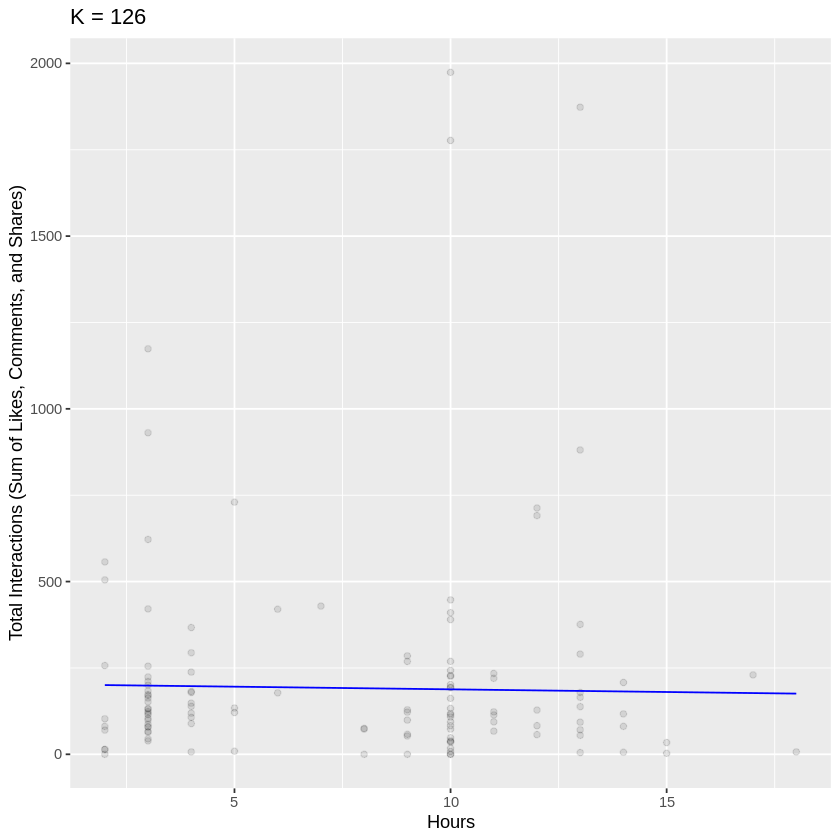

In [19]:
fb_spec <- linear_reg() %>%
    set_engine("lm") %>%
    set_mode("regression")

fb_recipe <- recipe(total_interactions ~ post_hour, data = facebook_train)

fb_fit <- workflow() %>%
    add_recipe(fb_recipe) %>%
    add_model(fb_spec) %>%
    fit(data = facebook_train)

fb_test_results <- fb_fit %>%
    predict(facebook_test) %>%
    bind_cols(facebook_test) %>%
    metrics(truth = total_interactions, estimate = .pred)
fb_test_results

facebook_linear_preds <- fb_fit %>%
                   predict(facebook_test) %>%
                   bind_cols(facebook_test)
facebook_linear_preds
facebook_plot_final <- ggplot(facebook_linear_preds, aes(x = post_hour, y = total_interactions)) +
                       geom_point(alpha = 0.1) +
                       xlab("Hours") +
                       ylab("Total Interactions (Sum of Likes, Comments, and Shares)") +
                       geom_line(data = facebook_linear_preds, aes(x = post_hour, y = .pred), color = "blue") +
                       ggtitle(paste0("K = ", k_min))
facebook_plot_final